# Preprocessing Demo

In this notebook, we will explore downloading and preprocessing a multisample spatial transcriptomics dataset for analysis with Popari. In particular, we will be working with a dataset profiling the progression of **Alzheimer's Disease (AD)** in **mouse brain** tissue.

In [131]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt

import anndata as ad
import scanpy as sc
import squidpy as sq

from popari.components import PopariDataset
from popari.io import save_anndata, load_anndata

## Load data
Here we load the raw data. This process will vary considerably from dataset to dataset, as there is no standard data format for the outputs of spatial transcriptomics assay. However, generally the expression data and spatial coordinate information will be available in two separate files.

In [41]:
data_directory = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/data/STARmapPlus/SCP1375/")

### Load raw expression

In [5]:
dataset_path = data_directory / "expression" / "expression_matrix_raw.csv"
raw_expression = pd.read_csv(dataset_path)

### Load spatial coordinates

In [81]:
eight_month_coordinates = pd.read_csv(data_directory / 'cluster' / 'spatial_8months-disease-replicate_1.csv', header=0, skiprows=lambda x: x == 1)
thirteen_month_coordinates = pd.read_csv(data_directory / 'cluster' / 'spatial_13months-disease-replicate_1.csv', header=0, skiprows=lambda x: x == 1)

spatial_info = [
    eight_month_coordinates,
    thirteen_month_coordinates
]

dataset_names = [
    'eight_month',
    'thirteen_month',
]

From viewing the raw expression dataframe, we can see that there are many `1`s and `0`s.

In [82]:
raw_expression

,GENE,1,3,4,5,6,7,8,9,10,...,76834,76836,76837,76838,76839,76840,76842,76843,76845,76846
0,A2m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aagab,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aak1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abca2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Abca7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,Zhx1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2762,Zic1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2763,Zim1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2764,Zmym1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Reformat
Here we reformat the raw data and into AnnData objects.

In [83]:
def reformat_dataset(spatial_metadata, raw_dataframe):
    # Reformatting
    spatial_metadata['X'] = spatial_metadata['X'].astype('int')
    spatial_metadata['Y'] = spatial_metadata['Y'].astype('int')
    idx = spatial_metadata['NAME'].astype(str)
    
    raw_values = raw_dataframe.loc[:, idx]
    
    dataset = ad.AnnData(csr_matrix(raw_values.T.values), dtype=np.float64)
    dataset.obs_names = [f"Cell_{i:d}" for i in range(dataset.n_obs)]
    dataset.var_names = [raw_dataframe['GENE'].iloc[i] for i in range(dataset.n_vars)]\
        
    dataset.obsm['spatial'] = spatial_metadata[['X', 'Y']].values
    
    return dataset

In [101]:
reformatted_datasets = [reformat_dataset(spatial_metadata, raw_expression) for spatial_metadata in spatial_info]

## Data transformation
To match the Popari probabilistic model, we transform the raw count data such that the data is better approximated by a truncated Gaussian; this is accomplished by the `log1p` transform. We also normalize the counts per each spot and only keep highly-variable genes (HVGs). All of these steps together constitute the standard single-cell RNA-seq preprocessing pipeline; see [here](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) for an example from Scanpy's documentation.

Note that we merge the datasets together before computing the HVGs.

In [111]:
def transform_datasets(datasets, dataset_names):
    merged_dataset = ad.concat(datasets, label="batch", keys=dataset_names, merge="unique", uns_merge="unique")
    
    sc.pp.normalize_total(merged_dataset, inplace=True)
    sc.pp.log1p(merged_dataset)
    sc.pp.highly_variable_genes(merged_dataset, n_top_genes=500)
    merged_dataset.var.highly_variable
    
    transformed_datasets = []
    for dataset, name in zip(datasets, dataset_names):
        sc.pp.normalize_total(dataset, inplace=True)
        sc.pp.log1p(dataset)
        dataset = dataset[:, merged_dataset.var.highly_variable]
        transformed_datasets.append(PopariDataset(dataset, name))
    
    return transformed_datasets

In [108]:
transformed_datasets = transform_datasets(reformatted_datasets, dataset_names)

/home/shahula/bin/miniconda3/envs/spicemix_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/shahula/bin/miniconda3/envs/spicemix_distribution/lib/python3.8/site-packages/popari/components.py:33: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  super().__init__(


## Graph construction
For Popari, we need an adjacency matrix describing which spots are neighbors of each other. We can call the `compute_spatial_neighbors` function from the `PopariDataset` object to construct this graph. This function uses Delaunay triangulation (with some filtering of large edges) to construct the graph.

In [109]:
for transformed_dataset in transformed_datasets:
    transformed_dataset.compute_spatial_neighbors()

## Saving to disk

In [110]:
save_anndata(data_directory / f"preprocessed_dataset.h5ad", transformed_datasets, dataset_names)

/home/shahula/bin/miniconda3/envs/spicemix_distribution/lib/python3.8/site-packages/popari/io.py:101: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_copy = ad.AnnData(
/home/shahula/bin/miniconda3/envs/spicemix_distribution/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 18558 × 500
    obs: 'batch'
    uns: 'log1p', 'spatial_neighbors', 'adjacency_matrix'
    obsm: 'spatial'

## Quality control (QC)
Before running Popari, we must ensure that the preprocessing steps yielded the expected results. 

In [158]:
from popari._dataset_utils import _plot_in_situ
from scipy.sparse import issparse

In [128]:
for dataset in transformed_datasets:
    sc.pp.calculate_qc_metrics(dataset, percent_top=None, log1p=False, inplace=True)
    dataset.obs["library_size"] = dataset.X.sum(axis=1)

In [161]:
def plot_sparsity(dataset):
    X = dataset.X
    if issparse(X):
        X = X.toarray()
        
    raw_data = X.flatten()
    raw_data_clipped = raw_data
    raw_data_clipped = raw_data_clipped[(raw_data_clipped > 1e-6) & (raw_data_clipped < np.percentile(raw_data_clipped, 99.9))]

    plt.title("Raw data sparsity")
    plt.xlabel("Value")
    plt.ylabel("# of counts")
    plt.hist(raw_data, bins=20)
    plt.show()

    plt.figure()
    plt.title("Clipped data sparsity")
    plt.xlabel("Value")
    plt.ylabel("# of counts")
    plt.hist(raw_data_clipped, bins=20)
    plt.show()
    
    sparsity = (raw_data == 0).sum() / raw_data.size
    print(f"Raw data sparsity level: {sparsity}")

### Metric plots
As revealed by the below plots, the data is very sparse.

eight_month


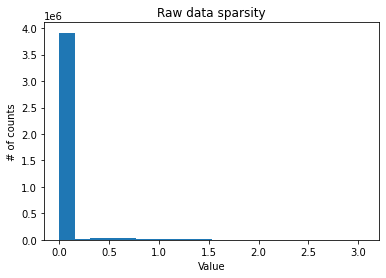

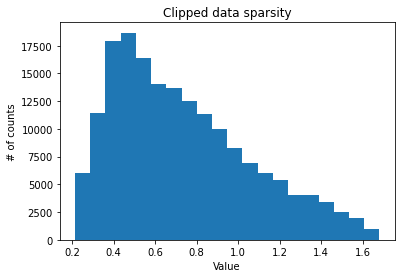

Raw data sparsity level: 0.9560845345712191


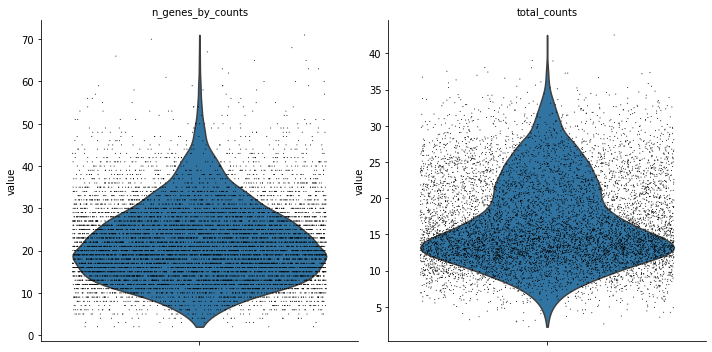

thirteen_month


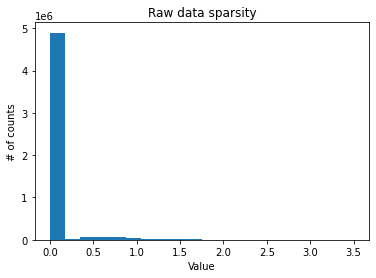

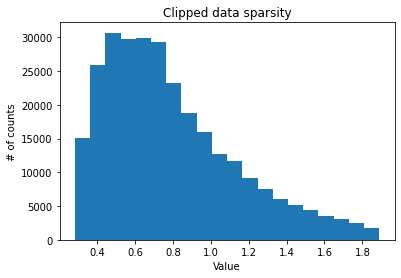

Raw data sparsity level: 0.9437981102969534


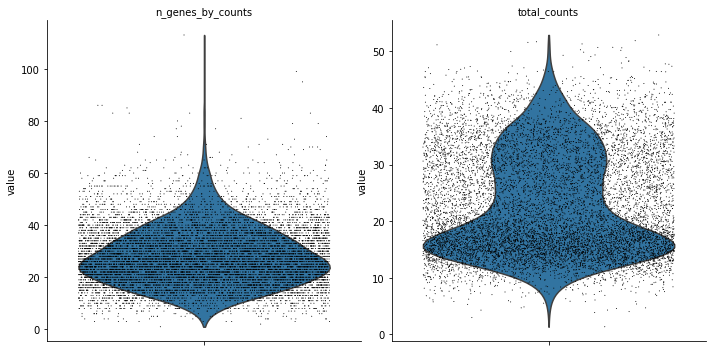

In [145]:
for dataset in transformed_datasets:
    print(dataset.name)
    plot_sparsity(dataset)
    sc.pl.violin(dataset, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

### _in situ_ plot
Here we plot the spots (along with the spatial neighbor graph) _in situ_. Notice that the edges appear reasonable; however, we also see that the total number of preprocessed counts may be a confounding factor. 

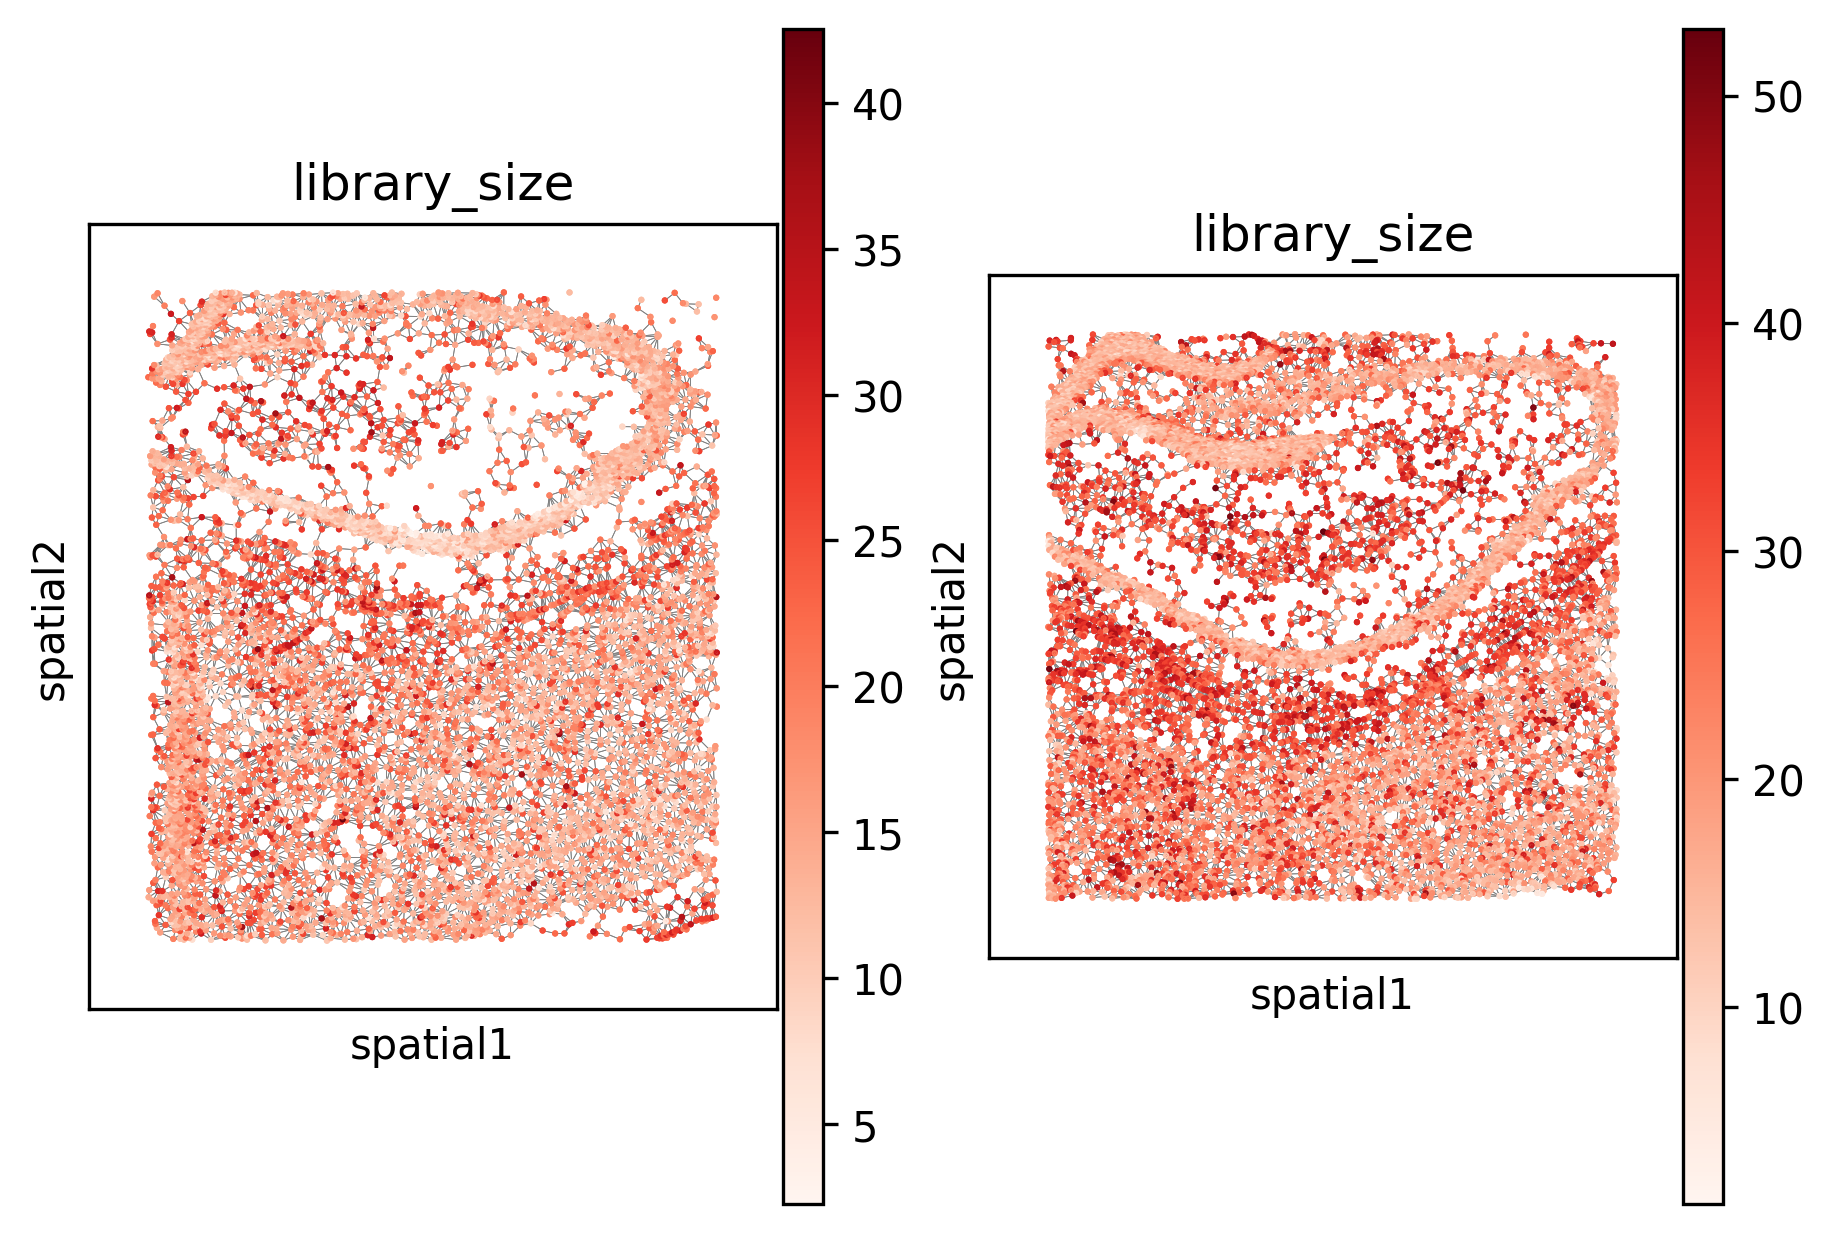

In [124]:
_ = _plot_in_situ(transformed_datasets, size=1, color="library_size", cmap="Reds")

## Overcoming sparsity with spatial binning
From the QC steps, we can see that there are some undesirable characteristics of the STARmap Plus data which may obscure important biological signals. One possible the issue is the inherent sparsity. We can combat this by spatially downsampling the data and combining spots into bins.

In [28]:
from popari._dataset_utils import _spatial_binning

In [163]:
binned_datasets = []
for dataset in transformed_datasets:
    binned_dataset = _spatial_binning(dataset, chunks=8, downsample_rate=0.2)
    print(f"Dataset downsampled from {len(dataset)} spots to {len(binned_dataset)} spots.")
    binned_datasets.append(binned_dataset)

/home/shahula/bin/miniconda3/envs/spicemix_distribution/lib/python3.8/site-packages/popari/_dataset_utils.py:700: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  binned_dataset = ad.AnnData(X=filtered_bin_expression)


Dataset downsampled from 8186 spots to 1342 spots.


/home/shahula/bin/miniconda3/envs/spicemix_distribution/lib/python3.8/site-packages/popari/_dataset_utils.py:700: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  binned_dataset = ad.AnnData(X=filtered_bin_expression)


Dataset downsampled from 10372 spots to 1924 spots.


eight_month_binned


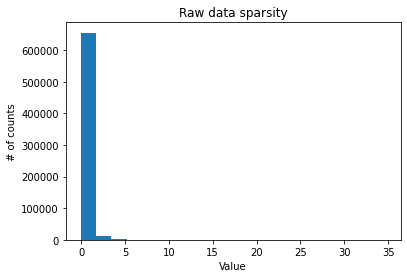

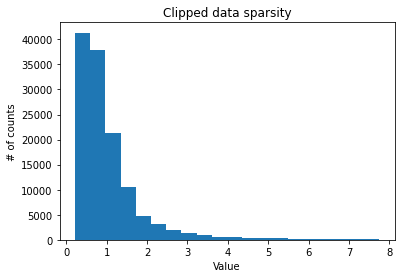

Raw data sparsity level: 0.8113695976154992
thirteen_month_binned


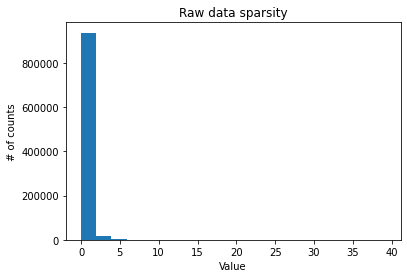

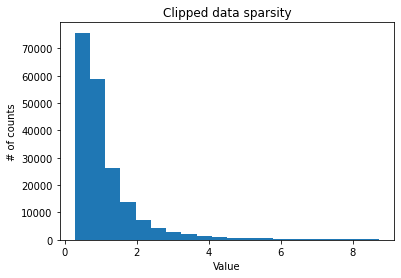

Raw data sparsity level: 0.7937463617463617


In [164]:
for dataset in binned_datasets:
    print(dataset.name)
    plot_sparsity(dataset)

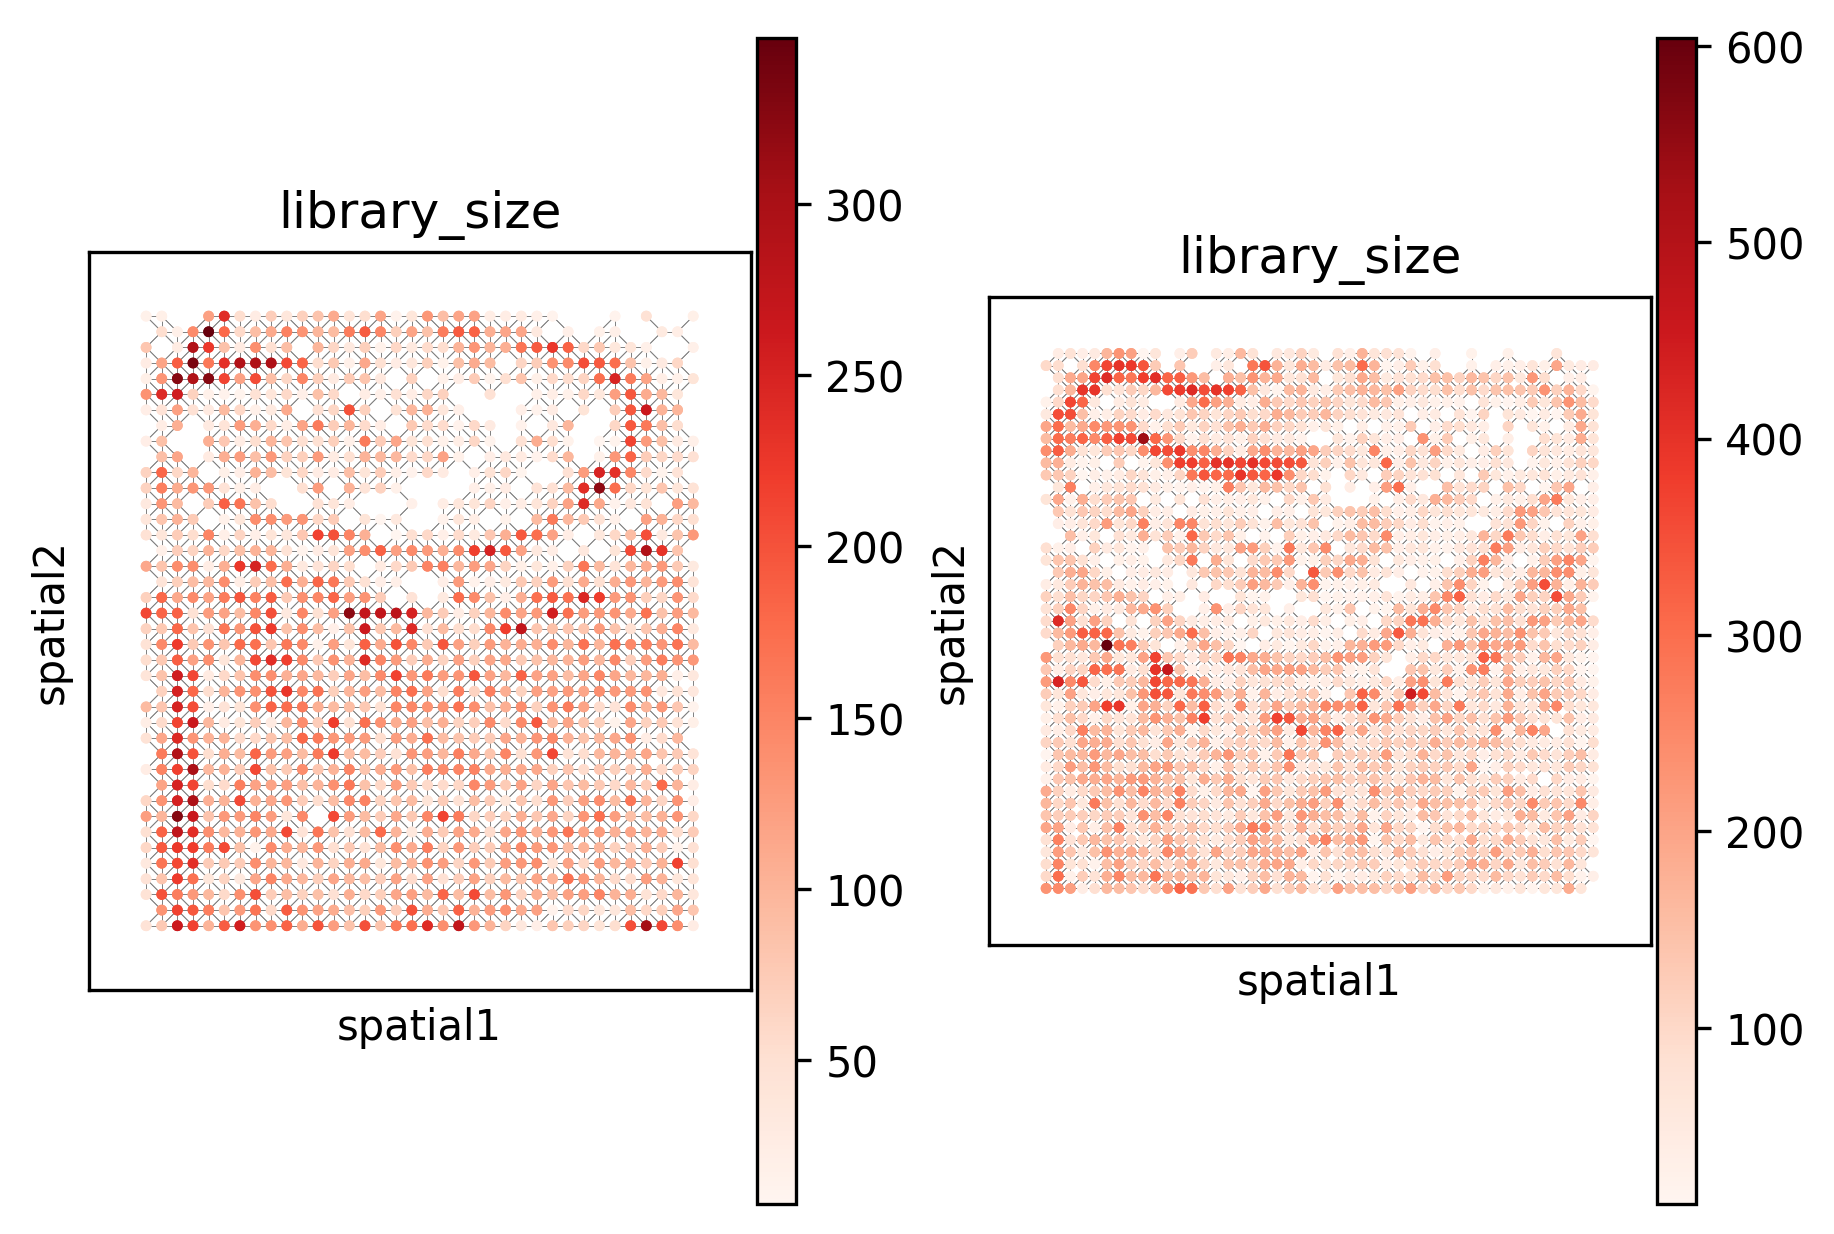

In [166]:
_ = _plot_in_situ(binned_datasets, size=10, color="library_size", cmap="Reds")

From the above plots, it is clear that binning significantly improves the sparsity 

In [ ]:
save_anndata(data_directory / f"preprocessed_binned_dataset.h5ad", binned_datasets, dataset_names)